In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 10)
pd.set_option('max_colwidth', 1600)
import re
from sklearn import linear_model
from scipy import stats
import mpld3
mpld3.enable_notebook()

In [2]:
LINEUP_THRESHOLD = 24 * 60

In [3]:
def fit(A, b):
    reg = linear_model.BayesianRidge(fit_intercept=False, verbose=True)
    reg.fit(A, b)
    return reg.coef_

In [4]:
def plot_scatter_label(x, y, title = "Graph", trendline = False, labels = None):
    x_np = np.array(x).reshape((-1, 1))
    y_np = np.array(y)

    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y)
    
    if trendline is True:
        r = linear_model.LinearRegression()
        r.fit(x_np, y_np)
        ax.plot(x, r.predict(x_np))
        
    x_min = min(x)
    x_max = max(x)
    x_pad = (x_max - x_min) * 0.05
    ax.set_xlim(x_min - x_pad, x_max + x_pad)
    y_min = min(y)
    y_max = max(y)
    y_pad = (y_max - y_min) * 0.05
    ax.set_ylim(y_min - y_pad, y_max + y_pad)
    
    final_title = "%s (r = %f)" % (title, np.corrcoef(x, y)[0][1]) if trendline is True else title
    plt.title(final_title)
    
    if labels is not None:
        tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
        mpld3.plugins.connect(fig, tooltip)
        
    plt.show()

In [5]:
def plot_histogram(x, title = "Graph"):
    mu = np.mean(x)
    sd = np.var(x) ** 0.5
    plt.hist(x, bins='auto', normed=True)
    x_sorted = sorted(x)
    plt.plot(x_sorted, stats.norm.pdf(x_sorted, mu, sd))
    plt.title(title)
    plt.show()

In [6]:
def findMatchingLineupAdvanced(lineup, nba_lineups_advanced):
    players = lineup.split("+")    
    player_first_names = map(lambda name: re.search(r"^[A-Z][a-z]*", name).group(), players)
    player_last_names = map(lambda name: re.search(r"[A-Z][a-z]*$", name).group(), players)
    return nba_lineups_advanced[nba_lineups_advanced['GROUP_NAME'].str.contains(player_first_names[0]) & nba_lineups_advanced['GROUP_NAME'].str.contains(player_first_names[1]) & nba_lineups_advanced['GROUP_NAME'].str.contains(player_first_names[2]) & nba_lineups_advanced['GROUP_NAME'].str.contains(player_first_names[3]) & nba_lineups_advanced['GROUP_NAME'].str.contains(player_first_names[4])  & nba_lineups_advanced['GROUP_NAME'].str.contains(player_last_names[0]) & nba_lineups_advanced['GROUP_NAME'].str.contains(player_last_names[1]) & nba_lineups_advanced['GROUP_NAME'].str.contains(player_last_names[2]) & nba_lineups_advanced['GROUP_NAME'].str.contains(player_last_names[3]) & nba_lineups_advanced['GROUP_NAME'].str.contains(player_last_names[4])]

In [7]:
def findMatchingPlayerAdvanced(name, players_advanced):
    first_name = re.search(r"^[A-Z][a-z]*", name).group()
    last_name = re.search(r"[A-Z][a-z]*$", name).group()
    return players_advanced[players_advanced['PLAYER_NAME'].str.contains(first_name) & players_advanced['PLAYER_NAME'].str.contains(last_name)]

In [8]:
def predict(YEAR):
    print("Reading data...")
        
    # Read matchups, filtering out matchups shorter than 24 seconds (1 shot clock)
    all_matchups = pd.read_csv('data/matchups/%s.csv' % YEAR, names=['home_lineup', 'away_lineup', 'home_score', 'away_score', 'time'])
    all_matchups = all_matchups[all_matchups.time >= 24]
    
    # Read official NBA lineup statistics for given year
    nba_lineups_advanced = pd.read_csv('data/lineups/nba_lineups_advanced_%s.csv' % YEAR, usecols=['GROUP_NAME', 'TEAM_ABBREVIATION', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'OFF_RATING', 'DEF_RATING', 'NET_RATING', 'EFG_PCT', 'AST_PCT'])

    # Read official NBA player statistics for given year
    players_advanced = pd.read_csv('data/players/players_advanced_%s.csv' % YEAR, usecols=['PLAYER_NAME', 'NET_RATING', 'TEAM_ID'])
    
    print("Processing lineups and matchups...")
    
    # Create dictionary for all lineups by total active time
    lineup_dict_by_time = {}
    num_matchups = len(all_matchups.index)
    for i in range(0, num_matchups):
        home = all_matchups['home_lineup'].values[i]
        away = all_matchups['away_lineup'].values[i]
        time = all_matchups['time'].values[i]
        if home not in lineup_dict_by_time:
            lineup_dict_by_time[home] = time
        else:
            lineup_dict_by_time[home] += time
        if away not in lineup_dict_by_time:
            lineup_dict_by_time[away] = time
        else:
            lineup_dict_by_time[away] += time
            
    # Filter out lineups with insufficient playing time
    valid_lineups_by_time = dict((key, value) for key, value in lineup_dict_by_time.iteritems() if value >= LINEUP_THRESHOLD)
    
    # Get ID of lineup using valid_lineup_dict. Get lineup by ID using valid_lineup_lookup
    lineup_counter = 0
    valid_lineup_dict = {}
    for k, v in valid_lineups_by_time.iteritems():
        if k not in valid_lineup_dict:
            valid_lineup_dict[k] = lineup_counter
            lineup_counter += 1
    valid_lineup_lookup = dict((v, k) for (k, v) in valid_lineup_dict.iteritems())
    
    # Filter all matchups to only consider qualifying lineups
    valid_matchups_bool = all_matchups.isin({'home_lineup': valid_lineups_by_time.keys(), 'away_lineup': valid_lineups_by_time.keys()})
    valid_matchups_bool['valid'] = valid_matchups_bool.apply(lambda x: (x['home_lineup'] and x['away_lineup']), axis = 1)
    valid_matchups = all_matchups[valid_matchups_bool['valid'] == True]
    
    # Get number of lineups and matchups
    num_lineups = len(valid_lineup_dict)
    num_matchups = len(valid_matchups.index)
    print("%d lineups, %d matchups"% (num_lineups, num_matchups))
    
    print("Regressing lineups...")
    # fit Ax = b
    # A is a matrix encoding matchups and home court advantage
    # b is a vector representing score differential
    # x is a weight vector encoding lineup strength and home court advantage
    A = np.zeros((num_matchups, num_lineups + 1))
    b = np.zeros(num_matchups)
    i = 0
    for idx, val in valid_matchups.iterrows():
        home_id = valid_lineup_dict[val['home_lineup']]
        away_id = valid_lineup_dict[val['away_lineup']]
        diff = val['home_score'] - val['away_score']
        time = val['time']
        A[i][home_id] = time ** 0.5
        A[i][away_id] = -1 * (time ** 0.5)
        A[i][num_lineups] = time ** 0.5
        b[i] = diff
        i += 1
    t = fit(A, b)
    
    print("Regression complete!")
    
    # Get lineup strengths and home court advantage
    lineup_strengths = t[0:-1]
    home_court_advantage = t[-1]
    print("Home court advantage: %f points per 48" % (home_court_advantage * 60 * 48))
    p_str_max = max(lineup_strengths)
    p_str_min = min(lineup_strengths)
    print("Best lineup beats worst lineup by %f points per 48" % ((p_str_max - p_str_min) * 60 * 48))
    
    # Plot histogram of lineup strengths
    plot_histogram(lineup_strengths, title = "Lineup Strengths")
    
    print("Processing lineups dataframe...")
    
    # Build lineups dataframe
    lineups_df = pd.DataFrame(data={'id': range(0, num_lineups)})
    lineups_df['lineup'] = lineups_df.apply(lambda x: valid_lineup_lookup[x['id']], axis=1)
    lineups_df['strength'] = lineups_df.apply(lambda x: lineup_strengths[x['id']], axis=1)
    lineups_df['minutes'] = lineups_df.apply(lambda x: valid_lineups_by_time[x['lineup']] / 60., axis=1)
    lineups_df['NET_RTG'] = [findMatchingLineupAdvanced(lineups_df['lineup'].values[i], nba_lineups_advanced)['NET_RATING'].values[0] if len(findMatchingLineupAdvanced(lineups_df['lineup'].values[i], nba_lineups_advanced)['NET_RATING'].values) > 0 else None for i in range(0, num_lineups)]

    
    # Plot computed lineup strength against team net rating
    _p = [(lineups_df['lineup'].values[i], lineups_df['strength'].values[i], findMatchingLineupAdvanced(lineups_df['lineup'].values[i], nba_lineups_advanced)['NET_RATING'].values) for i in range(0, num_lineups)]
    _p = filter(lambda p: p[2].size > 0, _p)
    _labels = map(lambda p: p[0].replace("+", ", "), _p)
    _x = map(lambda p: p[2][0], _p)
    _y = map(lambda p: p[1], _p)
    plot_scatter_label(_x, _y, title = 'Computed Strength vs. Net Rating', labels = _labels, trendline = True)
    
    # Plot computed lineup strength against total play time
    _p = [(lineups_df['lineup'].values[i], lineups_df['strength'].values[i], lineups_df['minutes'].values[i]) for i in range(0, num_lineups)]
    _p = filter(lambda p: p[2] >= 96, _p)
    _labels = map(lambda p: p[0].replace("+", ", "), _p)
    _x = map(lambda p: p[1], _p)
    _y = map(lambda p: p[2], _p)
    plot_scatter_label(_x, _y, title = 'Lineup Minutes Played vs. Computed Strength (at least 96 mins)', labels = _labels)
    
    print("Processing players...")
    
    # Build dict of lineups players are in
    player_lineups = {}
    for i in range(0, num_lineups):
        lineup = valid_lineup_lookup[i]
        lineup_players = lineup.split("+")
        for j in range(0, len(lineup_players)):
            player = lineup_players[j]
            if player not in player_lineups:
                player_lineups[player] = [{'id': i, 'mins': lineups_df[lineups_df['id'] == i]['minutes'].values[0], 'strength': lineups_df[lineups_df['id'] == i]['strength'].values[0]}]
            else:
                player_lineups[player] += [{'id': i, 'mins': lineups_df[lineups_df['id'] == i]['minutes'].values[0], 'strength': lineups_df[lineups_df['id'] == i]['strength'].values[0]}]
                
    # Get ID of player using player_dict. Get player by ID using player_lookup
    player_dict = {}
    num_players = 0
    for k, v in player_lineups.iteritems():
        player_dict[k] = num_players
        num_players += 1
    player_lookup = dict((v, k) for (k, v) in player_dict.iteritems())
    
    # Build 2d array to store computed player data
    player_list = []
    for player, data in player_lineups.iteritems():
        mins_sum = sum(map(lambda x: x['mins'], data))
        weighted_strength_sum = sum(map(lambda x: (x['mins']) * x['strength'], data))
        weighted_avg_strength = weighted_strength_sum / (1. * mins_sum)
        player_list.append([player, weighted_avg_strength, mins_sum, map(lambda x: x['id'], data), map(lambda x: x['mins'], data)])
        
    # Build players dataframe 
    players_df = pd.DataFrame(player_list, columns=['name','strength','minutes','lineups', 'lineup_minutes'])
    
    # Insert average player net ratings into lineup dataframe
    player_net_rtgs = []
    for i in range(0, num_lineups):
        players = lineups_df['lineup'].values[i].split('+')
        net_rtgs = map(lambda p: findMatchingPlayerAdvanced(p, players_advanced)['NET_RATING'].values[0] if len(findMatchingPlayerAdvanced(p, players_advanced)['NET_RATING'].values) > 0 else None, players)
        net_rtgs = [x for x in net_rtgs if x is not None]
        player_net_rtgs.append(sum(net_rtgs) / (1. * len(net_rtgs)))
    lineups_df['PLAYER_NET_RTGS'] = player_net_rtgs

    print("%d players, %d lineups"% (num_players, num_lineups))
    print("Regressing players...")
    
    # fit Ax = b
    # A is matrix encoding player net rating sum and player chemistry
    # b is vector representing strengths of lineups
    # x is vector encoding net rating multiplier and player chemistry
    A = np.zeros((num_lineups, num_players + 1))
    b = np.zeros((num_lineups))
    r = 0;
    for i, row in lineups_df.iterrows():
        players = row['lineup'].split('+')
        ids = map(lambda p: player_dict[p], players)
        for player_id in ids:
            A[r][player_id] = 1
        A[r][num_players] = row['PLAYER_NET_RTGS']
        b[r] = row['strength']
        r += 1
    t = fit(A, b)
        
    print("Regression complete!")
    
    # Get net rating multiplier and player chemistries
    netrtg_multiplier = t[-1]
    player_chemistries = t[0:-1]
        
    # Plot player chemistries on histogram
    plot_histogram(player_chemistries, title = "Player Chemistries")
    
    # Load player chemistries into player dataframe
    players_df['chemistry'] = players_df.apply(lambda p: player_chemistries[player_dict[p['name']]], axis=1)
    
    # Plot player chemistry against player strength
    points = []
    for i, row in players_df.iterrows():
        points.append([row['name'], row['strength'], row['chemistry']])
    _labels = map(lambda p: p[0], points)
    _x = map(lambda p: p[1], points)
    _y = map(lambda p: p[2], points)
    plot_scatter_label(_x, _y, labels = _labels, title = "Player Chemistry vs. Player Strength", trendline = True)
    
    # Plot predicted lineup strength from player net rating and player chemistry vs. actual net rating    
    _p = []
    for i, row in lineups_df[lineups_df['NET_RTG'].notnull()].iterrows():
        net_rtg = row['NET_RTG']
        pred_strength = row['PLAYER_NET_RTGS'] * netrtg_multiplier
        players = row['lineup'].split("+")
        for player in players:
            pred_strength += player_chemistries[player_dict[player]]
        _p.append((row['lineup'], net_rtg, pred_strength))
    _x = map(lambda p: p[1], _p)
    _y = map(lambda p: p[2], _p)
    _labels = map(lambda p: p[0], _p)
    plot_scatter_label(_x, _y, title = "Predicted lineup strength vs. True Net Rating", labels = _labels, trendline = True)    

    # Create regressor to predict lineup net rating from players, with and without chem
    lineups_with_netrtg = lineups_df[lineups_df['NET_RTG'].notnull()]
    net_rating_regressor = linear_model.LinearRegression()
    net_rating_regressor.fit(np.array(lineups_with_netrtg['strength'].values).reshape(-1, 1), np.array(lineups_with_netrtg['NET_RTG']))
    nochem_net_rating_regressor = linear_model.LinearRegression()
    nochem_net_rating_regressor.fit(np.array(lineups_with_netrtg['PLAYER_NET_RTGS'].values).reshape(-1, 1), np.array(lineups_with_netrtg['NET_RTG']))
    
    # Plot predicted lineup net rating from player net rating and player chemistry vs. actual net rating    
    _p = []
    for i, row in lineups_df[lineups_df['NET_RTG'].notnull()].iterrows():
        net_rtg = row['NET_RTG']
        pred_strength = row['PLAYER_NET_RTGS'] * netrtg_multiplier
        players = row['lineup'].split("+")
        for player in players:
            pred_strength += player_chemistries[player_dict[player]]
        _p.append((row['lineup'], net_rtg, net_rating_regressor.predict(pred_strength)[0]))
    _x = map(lambda p: p[1], _p)
    _y = map(lambda p: p[2], _p)
    _labels = map(lambda p: p[0], _p)
    plot_scatter_label(_x, _y, title = "Predicted Net Rating Using Chemistry vs. True Net Rating", labels = _labels, trendline = True)  
    
    # Plot predicted lineup net rating from player net rating and player chemistry vs. actual net rating    
    _p = []
    for i, row in lineups_df[lineups_df['NET_RTG'].notnull()].iterrows():
        net_rtg = row['NET_RTG']
        player_net_rtg = row['PLAYER_NET_RTGS']
        _p.append((row['lineup'], net_rtg, nochem_net_rating_regressor.predict(player_net_rtg)[0]))
    _x = map(lambda p: p[1], _p)
    _y = map(lambda p: p[2], _p)
    _labels = map(lambda p: p[0], _p)
    plot_scatter_label(_x, _y, title = "Predicted Net Rating Without Chemistry vs. True Net Rating", labels = _labels, trendline = True)  
    
    # Return function to predict net rating of any lineup
    def predict_from_lineup(lineup):
        players = lineup.split("+")
        net_rtgs = []
        chemistries = []
        for player in players:
            net_rtgs.append(findMatchingPlayerAdvanced(player, players_advanced)['NET_RATING'].values[0] if len(findMatchingPlayerAdvanced(player, players_advanced)['NET_RATING'].values) > 0 else None)
            chemistries.append(player_chemistries[player_dict[player]] if player in player_dict else 0)
        net_rtgs = filter(lambda x: x is not None, net_rtgs)
        avg_net_rtg = sum(net_rtgs) / (1 * len(net_rtgs))
        return net_rating_regressor.predict(avg_net_rtg * netrtg_multiplier + sum(chemistries))[0]
    
    return (lineups_df, players_df, predict_from_lineup)
            



Reading data...
Processing lineups and matchups...
690 lineups, 4819 matchups
Regressing lineups...
Convergence after  27  iterations
Regression complete!
Home court advantage: 37.451266 points per 48
Best lineup beats worst lineup by 548.055611 points per 48


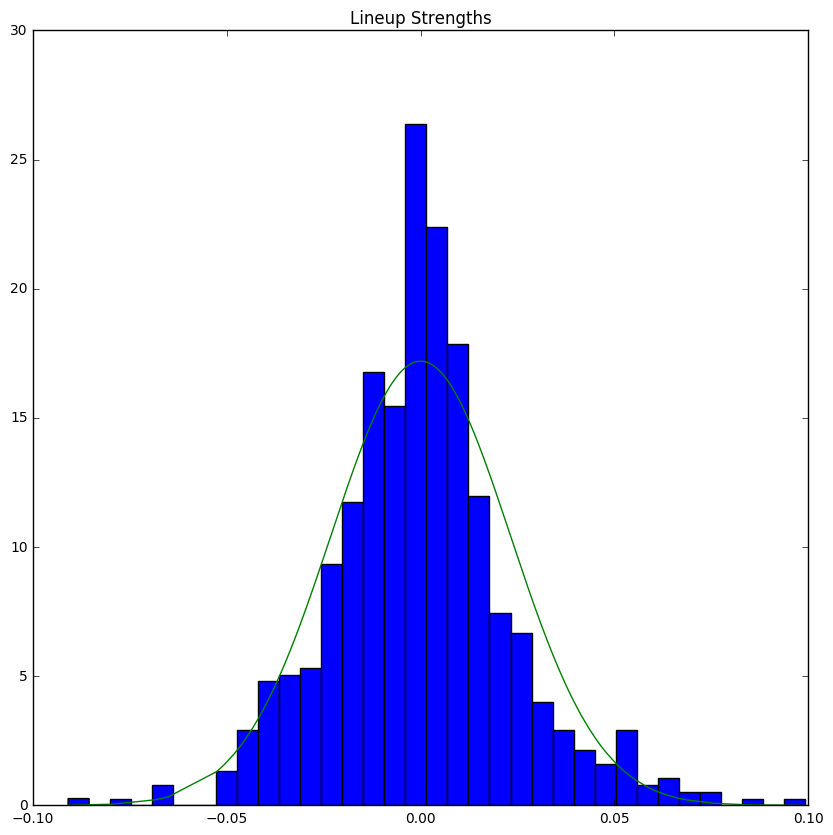

Processing lineups dataframe...


/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


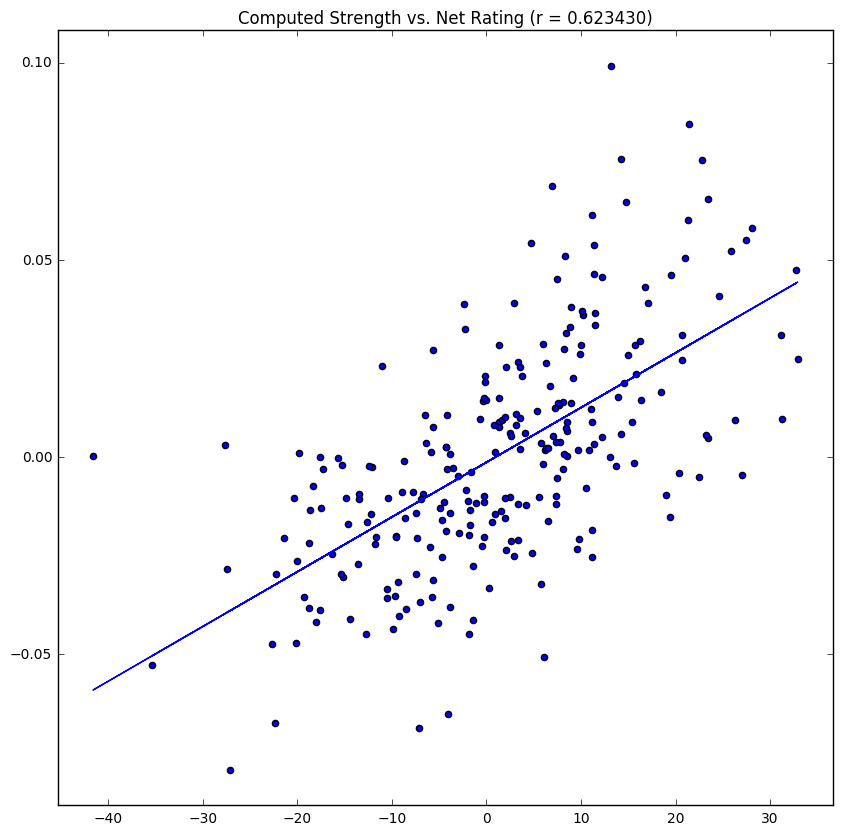

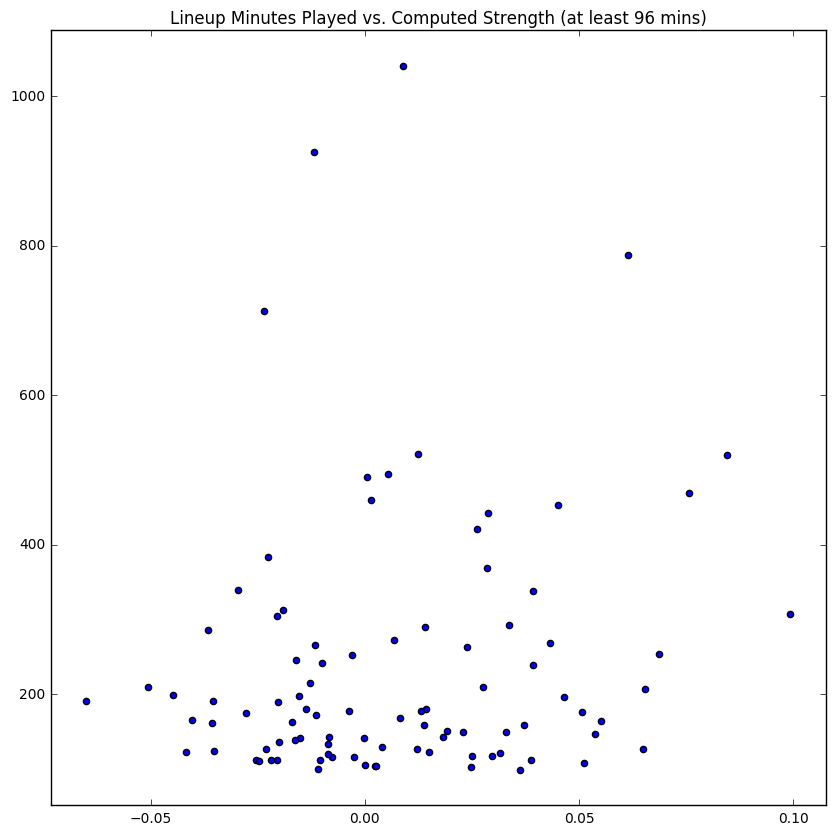

Processing players...
388 players, 690 lineups
Regressing players...
Convergence after  22  iterations
Regression complete!


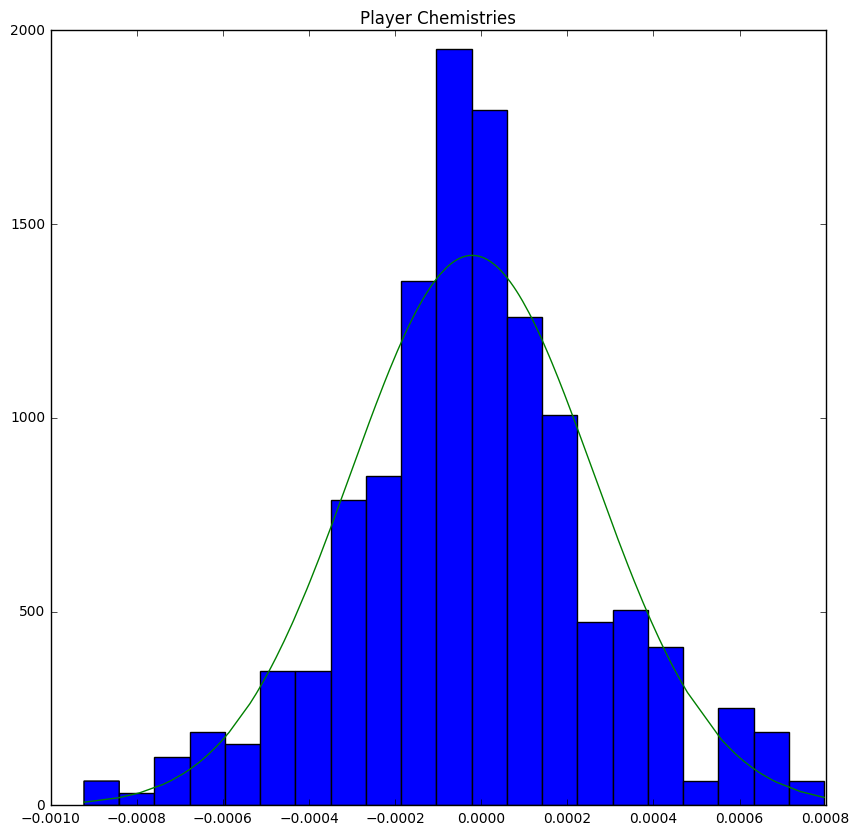

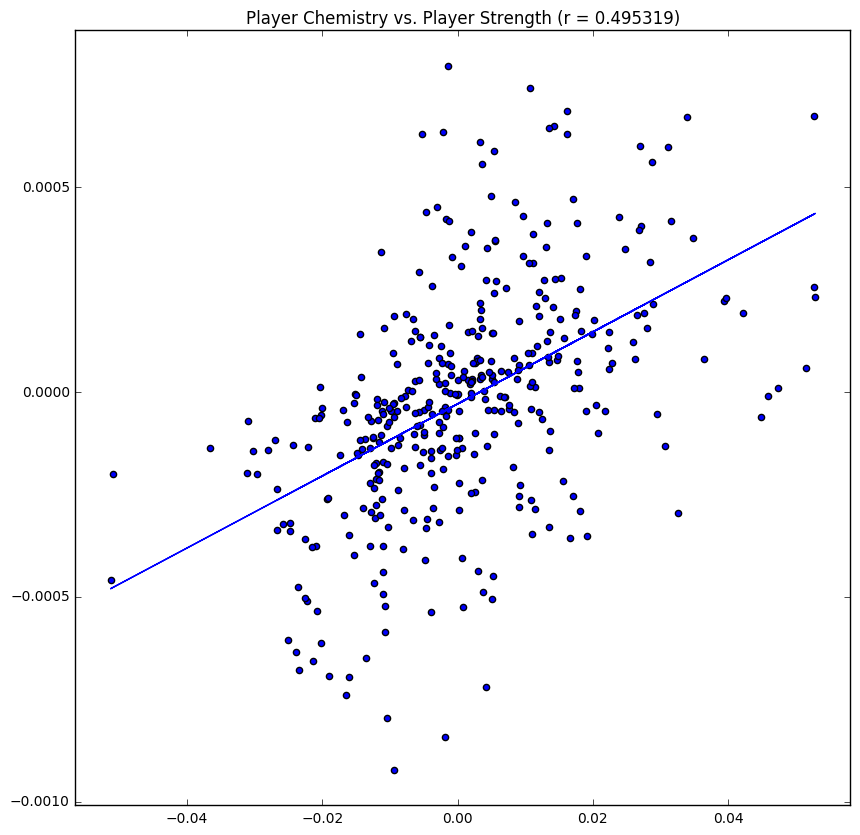

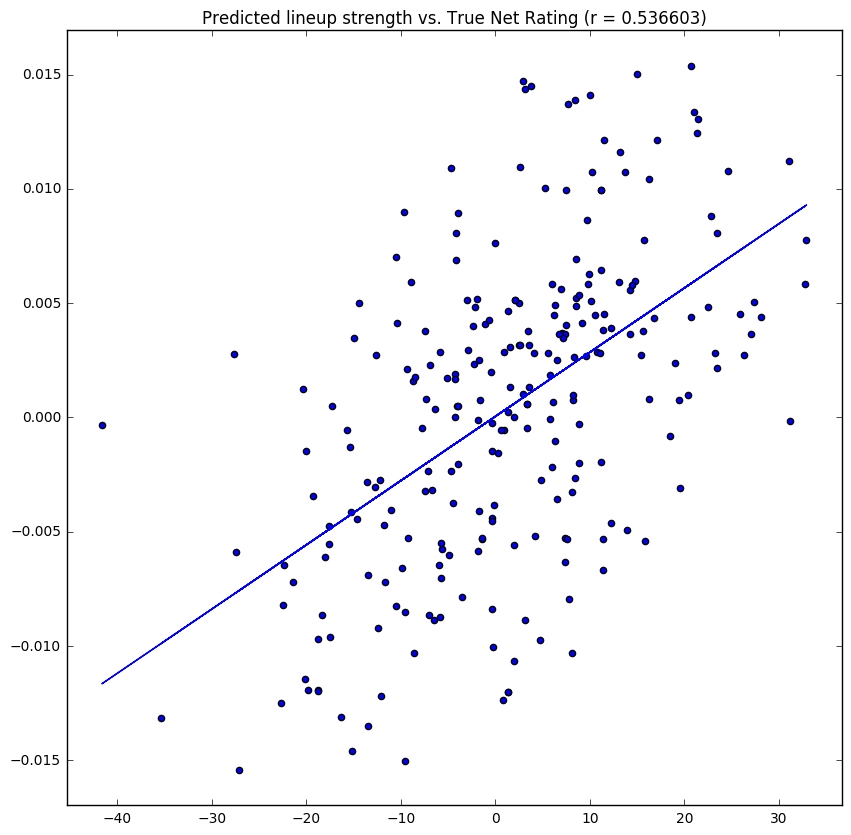

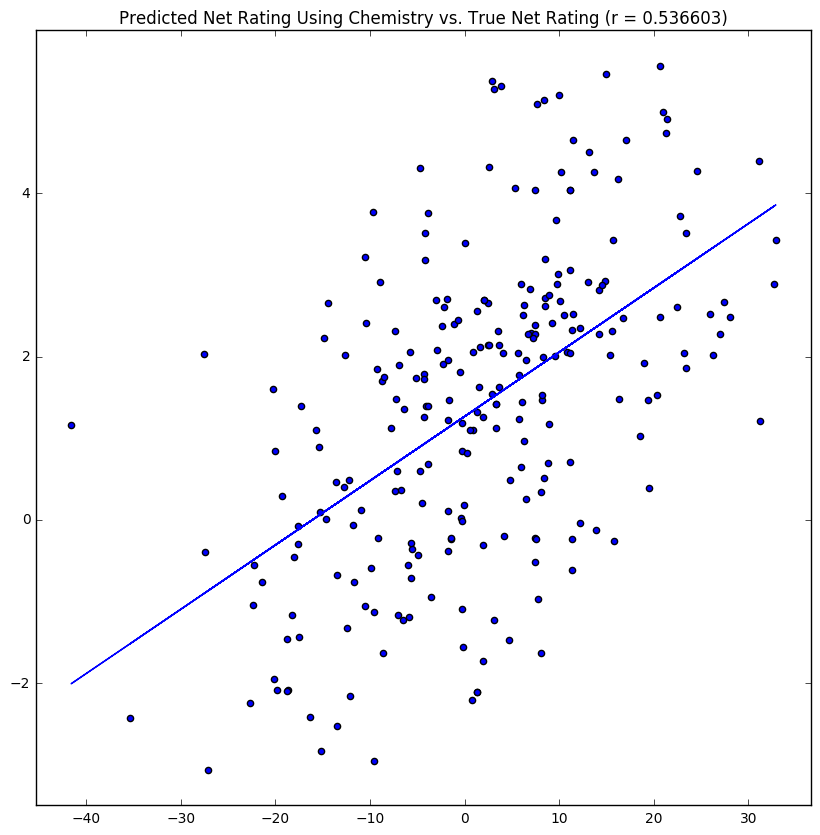

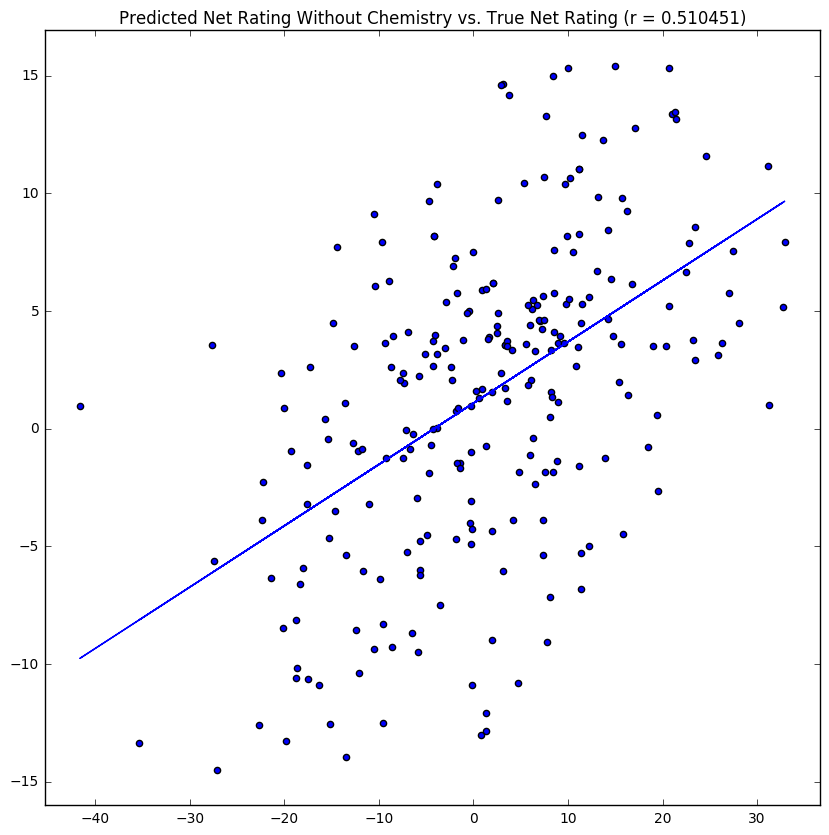

In [9]:
(lineups_df_201718, players_df_201718, predict_from_201718) = predict('201718')

In [10]:
lineups_df_201718.sort_values('strength')

,id,lineup,strength,minutes,NET_RTG,PLAYER_NET_RTGS
648,648,BuddyHield+GeorgeHill+JustinJackson+WillieCauleyStein+ZachRandolph,-0.090997,60.783333,NaN,-7.56
342,342,CristianoFelicio+DavidNwaba+KrisDunn+LauriMarkkanen+ZachLaVine,-0.079343,60.100000,-27.1,-11.32
465,465,BamAdebayo+DionWaiters+GoranDragic+JamesJohnson+JoshRichardson,-0.068559,53.116667,-7.1,-0.68
533,533,IsaiahThomas+JRSmith+JaeCrowder+LeBronJames+TristanThompson,-0.067305,85.866667,-22.4,-3.50
169,169,CarmeloAnthony+PaulGeorge+RussellWestbrook+StevenAdams+TerranceFerguson,-0.065094,191.316667,-4.1,2.28
564,564,JoshJackson+MarqueseChriss+TJWarren+TylerUlis+TysonChandler,-0.052629,66.466667,-35.4,-10.46
107,107,DennisSchroder+DewayneDedmon+KentBazemore+MikeMuscala+TaureanPrince,-0.050887,30.566667,NaN,-5.54
296,296,EricBledsoe+GiannisAntetokounmpo+KhrisMiddleton+ThonMaker+TonySnell,-0.050686,84.933333,6.1,0.90
220,220,DennisSmithJr+DirkNowitzki+HarrisonBarnes+MaximilianKleber+WesleyMatthews,-0.050593,209.183333,NaN,-6.35
443,443,DariusMiller+DeMarcusCousins+ETwaunMoore+JrueHoliday+RajonRondo,-0.048245,47.100000,NaN,2.50


In [11]:
players_df_201718[players_df_201718['minutes'] > 500].sort_values('strength')

,name,strength,minutes,lineups,lineup_minutes,chemistry
191,ZachRandolph,-0.025045,635.266667,"[28, 164, 190, 205, 303, 394, 510, 526, 600, 648]","[136.3, 45.6, 116.5, 31.0166666667, 111.333333333, 50.2666666667, 30.1666666667, 26.9833333333, 26.3166666667, 60.7833333333]",-0.000605
339,DennisSchroder,-0.023422,854.550000,"[59, 107, 114, 163, 188, 262, 298, 362, 371, 390, 459, 470, 577]","[27.4833333333, 30.5666666667, 79.2333333333, 32.3, 286.733333333, 43.6333333333, 49.75, 44.3166666667, 61.85, 26.1166666667, 56.9333333333, 89.55, 26.0833333333]",-0.000677
9,ElfridPayton,-0.022600,972.516667,"[155, 172, 259, 280, 338, 370, 375, 482, 527, 553, 556, 605, 683]","[27.6, 24.4333333333, 39.5166666667, 36.85, 198.466666667, 189.516666667, 49.9333333333, 32.65, 89.9, 26.15, 199.2, 30.1333333333, 28.1666666667]",-0.000358
364,LonzoBall,-0.022517,772.033333,"[71, 143, 207, 276, 399, 424, 426, 457]","[93.95, 165.266666667, 64.8666666667, 40.9, 33.4333333333, 26.1833333333, 172.783333333, 174.65]",-0.000502
183,AveryBradley,-0.022333,761.366667,"[58, 93, 121, 177, 206, 250, 286, 388, 417, 685]","[68.3333333333, 49.3, 37.2666666667, 24.1666666667, 51.3166666667, 93.4833333333, 32.95, 39.5333333333, 339.133333333, 25.8833333333]",-0.000509
214,KentBazemore,-0.021583,710.650000,"[59, 107, 114, 188, 262, 362, 390, 459, 470, 577]","[27.4833333333, 30.5666666667, 79.2333333333, 286.733333333, 43.6333333333, 44.3166666667, 26.1166666667, 56.9333333333, 89.55, 26.0833333333]",-0.000379
41,TaureanPrince,-0.021391,957.400000,"[79, 107, 114, 158, 163, 174, 188, 262, 298, 346, 362, 371, 390, 459, 470]","[26.2, 30.5666666667, 79.2333333333, 26.7333333333, 32.3, 54.0166666667, 286.733333333, 43.6333333333, 49.75, 49.4666666667, 44.3166666667, 61.85, 26.1166666667, 56.9333333333, 89.55]",-0.000657
130,WillieCauleyStein,-0.020927,723.633333,"[4, 28, 40, 164, 224, 303, 464, 510, 526, 532, 600, 629, 648]","[26.05, 136.3, 32.4833333333, 45.6, 67.8, 111.333333333, 74.2666666667, 30.1666666667, 26.9833333333, 53.55, 26.3166666667, 32.0, 60.7833333333]",-0.000376
357,KyleKuzma,-0.020733,712.650000,"[101, 143, 196, 207, 222, 264, 276, 424, 427, 457, 617]","[32.2666666667, 165.266666667, 41.1333333333, 64.8666666667, 52.2166666667, 53.65, 40.9, 26.1833333333, 30.6, 174.65, 30.9166666667]",-0.000534
279,ErsanIlyasova,-0.020187,730.983333,"[13, 109, 114, 163, 188, 201, 262, 275, 332, 362, 423, 577, 666]","[36.9833333333, 27.9333333333, 79.2333333333, 32.3, 286.733333333, 29.1666666667, 43.6333333333, 30.7166666667, 30.4833333333, 44.3166666667, 34.65, 26.0833333333, 28.75]",-0.000612


In [12]:
predict_from_201718('ChrisPaul+ClintCapela+JamesHarden+PJTucker+TrevorAriza')

5.3747980368007306

In [13]:
predict_from_201718('CarmeloAnthony+CoreyBrewer+PaulGeorge+StevenAdams+RussellWestbrook')

1.8171720367697355

Reading data...
Processing lineups and matchups...
754 lineups, 5606 matchups
Regressing lineups...
Convergence after  28  iterations
Regression complete!
Home court advantage: 58.357127 points per 48
Best lineup beats worst lineup by 355.973332 points per 48


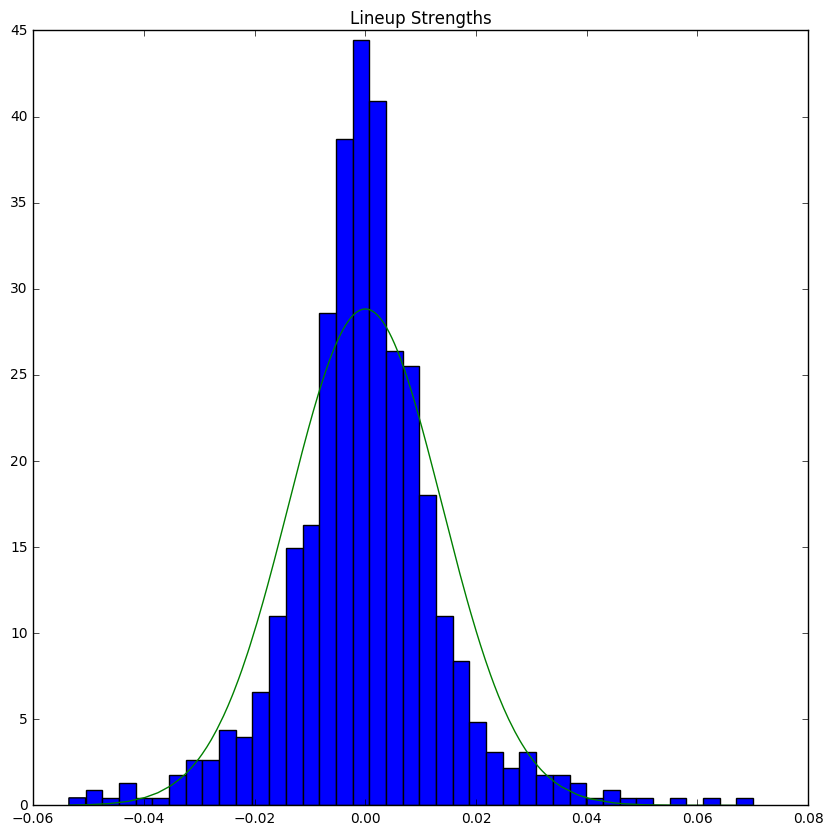

Processing lineups dataframe...


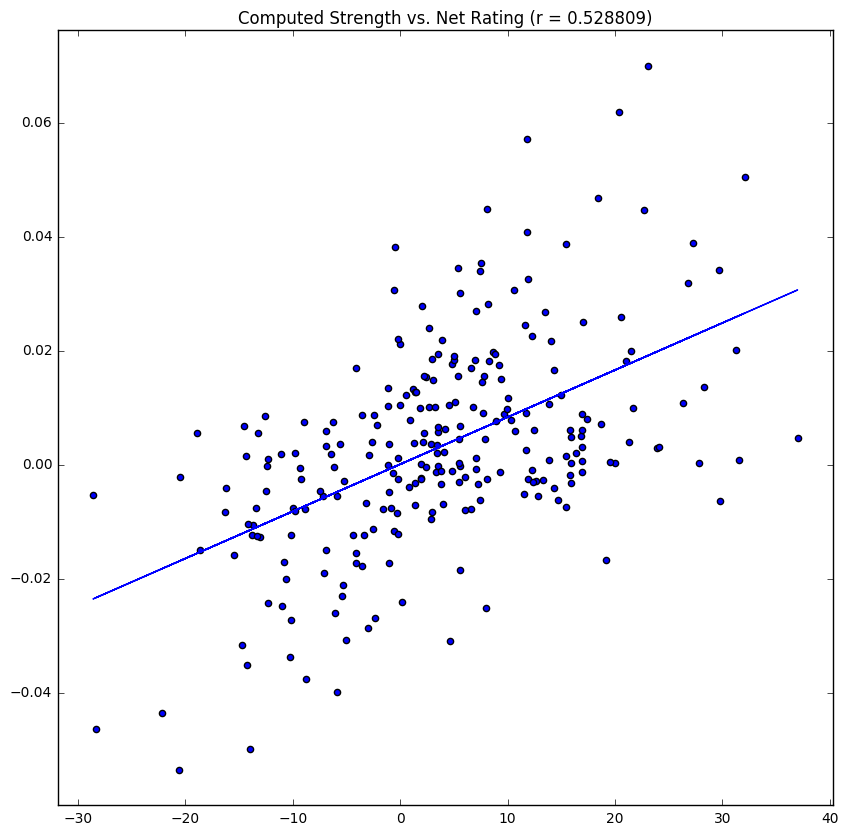

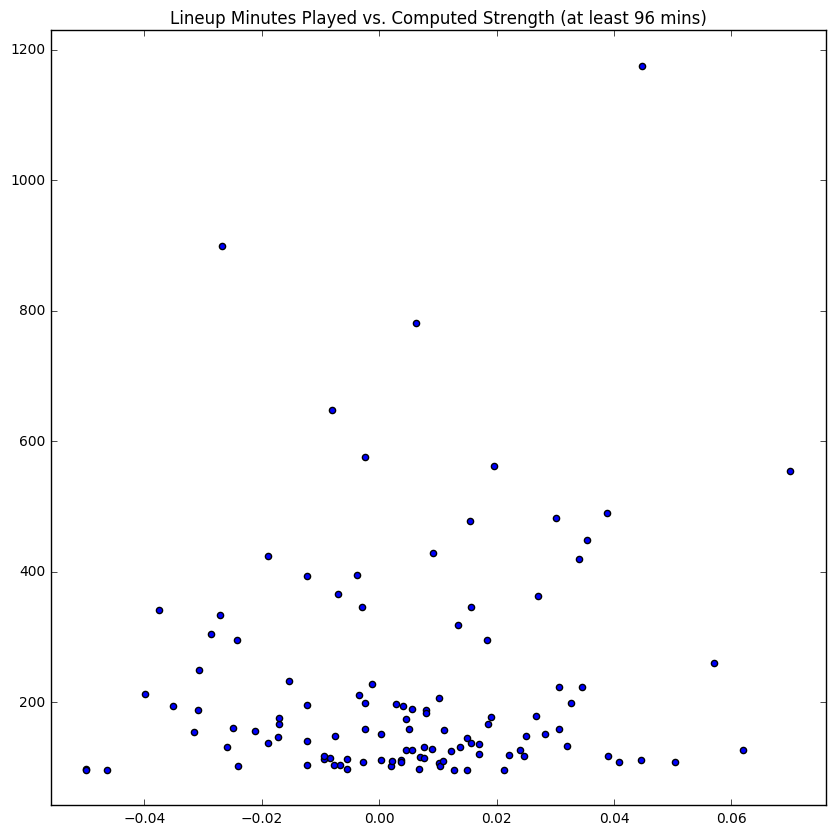

Processing players...
385 players, 754 lineups
Regressing players...
Convergence after  17  iterations
Regression complete!


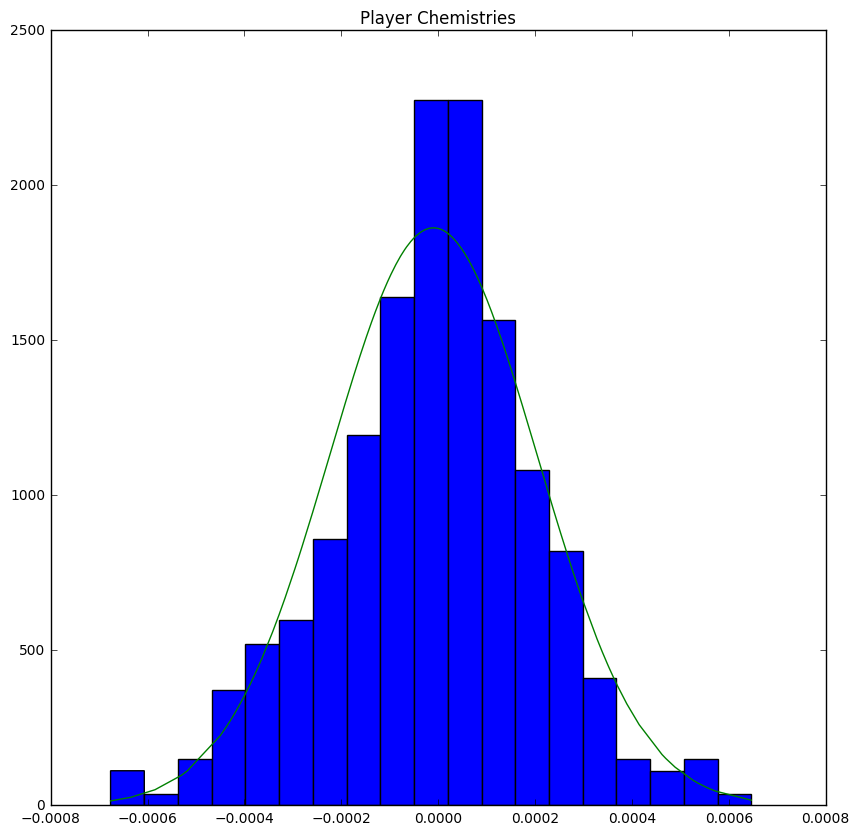

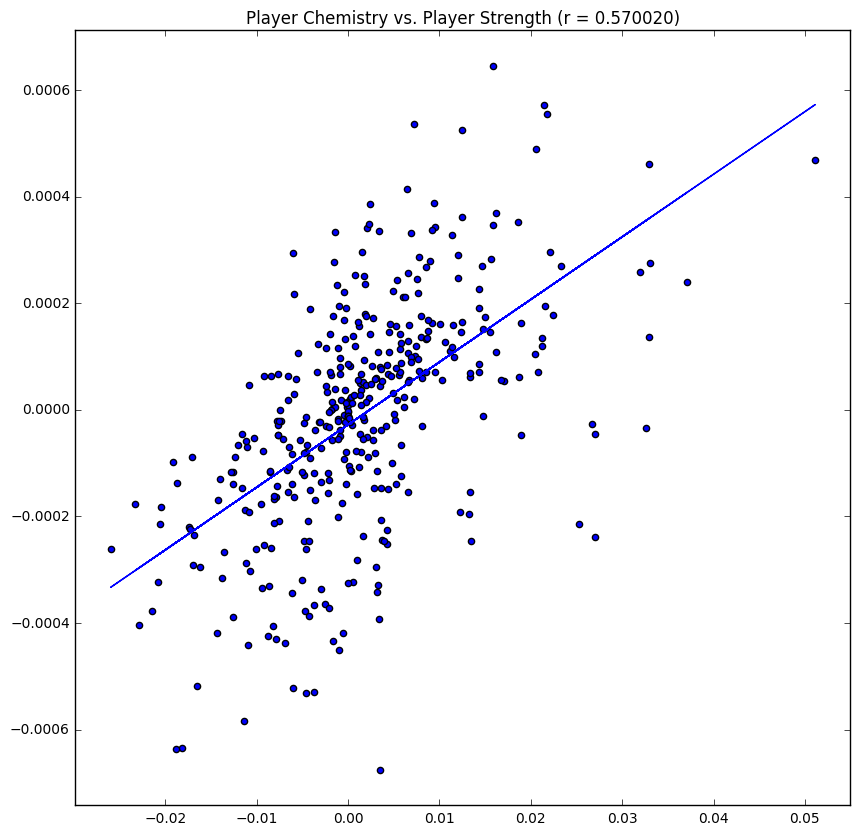

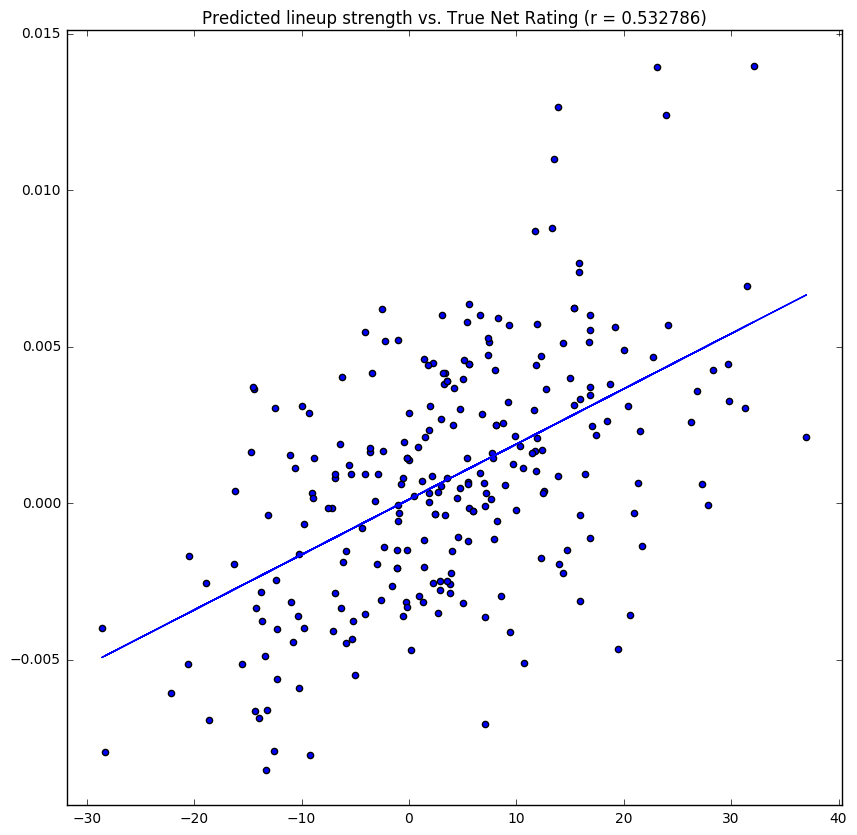

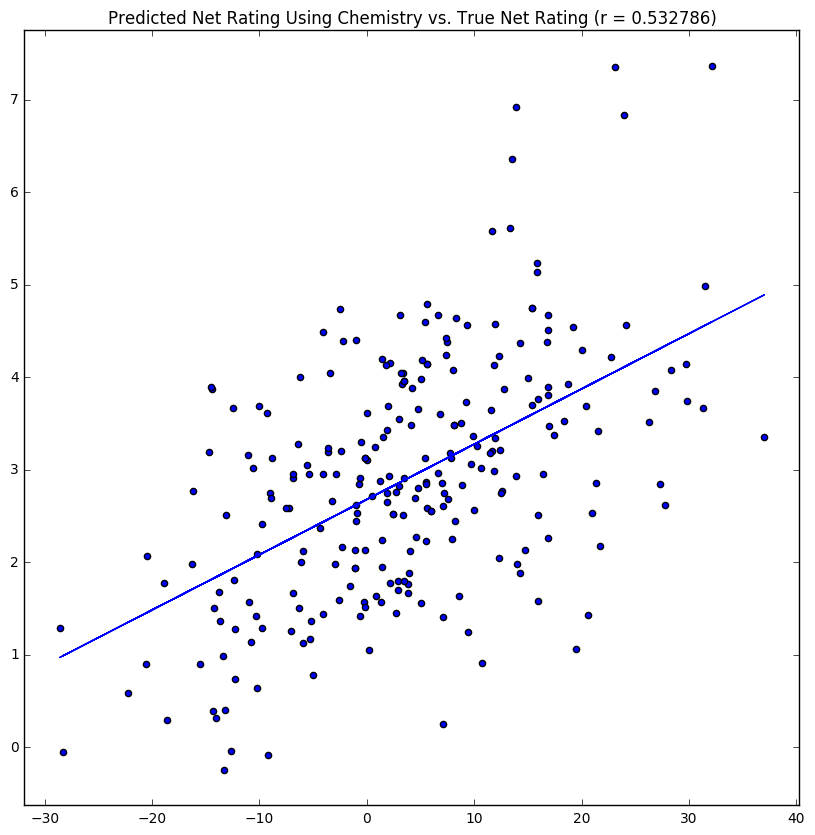

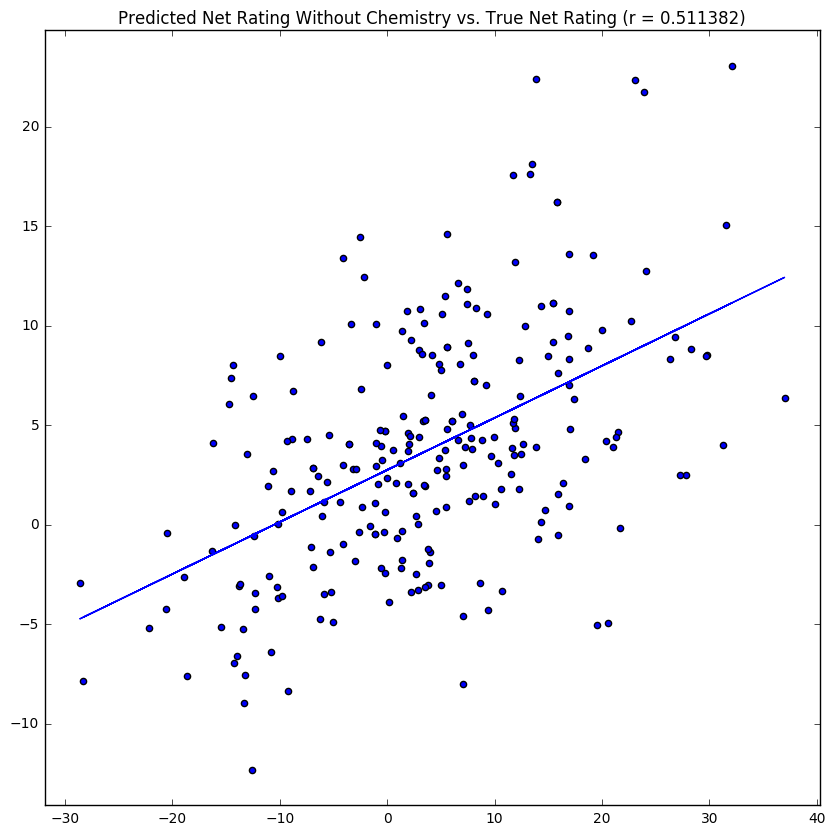

In [14]:
(lineups_df_201617, players_df_201617, predict_from_201617) = predict('201617')

In [15]:
predict_from_201617('LucMbahAMoute+ChrisPaul+RyanAnderson+ClintCapela+JamesHarden')

5.2582874232093006

In [16]:
predict_from_201617('CarmeloAnthony+PaulGeorge+AndreRoberson+StevenAdams+RussellWestbrook')

3.4559912771124486

In [17]:
predict_from_201617('RyanAnderson+TrevorAriza+EricGordon+ClintCapela+JamesHarden')

4.635826784220451

In [18]:
predict_from_201617('VictorOladipo+TajGibson+AndreRoberson+StevenAdams+RussellWestbrook')

4.1270915353869011

In [19]:
lineups_df_201718_netrtg = lineups_df_201718[lineups_df_201718['NET_RTG'].notnull()]
lineups_df_201718_netrtg = lineups_df_201718_netrtg[lineups_df_201718_netrtg['minutes'] > 120]

In [20]:
lineups_df_201718_netrtg['pred_rating'] = lineups_df_201718_netrtg.apply(lambda row: predict_from_201718(row['lineup']), axis=1)
lineups_df_201718_netrtg['pred_rating_201617'] = lineups_df_201718_netrtg.apply(lambda row: predict_from_201617(row['lineup']), axis=1)

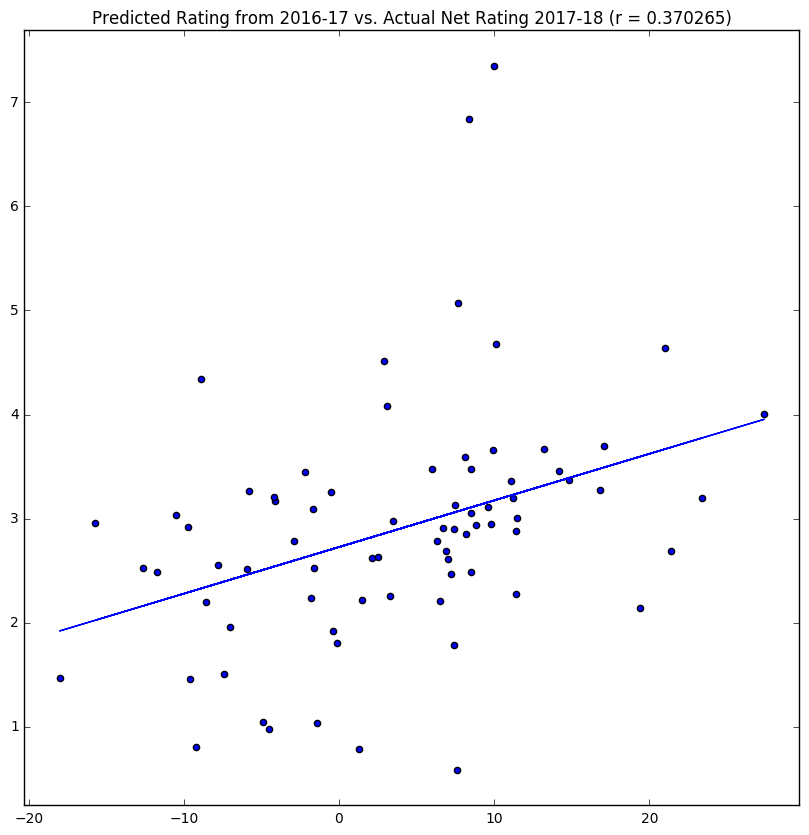

In [21]:
lineups_df_201718_netrtg[lineups_df_201718_netrtg['minutes'] > 120].sort_values('pred_rating_201617')
_x = lineups_df_201718_netrtg['NET_RTG'].values
_y = lineups_df_201718_netrtg['pred_rating_201617'].values
_labels = list(lineups_df_201718_netrtg['lineup'].values)

plot_scatter_label(_x, _y, title = "Predicted Rating from 2016-17 vs. Actual Net Rating 2017-18", labels=_labels, trendline = True)